In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasmdetectionprocessed/SarcasmDetectionProcessed.csv
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [19]:
# import packages
import json
import os 
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics

Load data into `Pandas.DataFrame`

In [20]:
df = pd.read_csv('../input/sarcasmdetectionprocessed/SarcasmDetectionProcessed.csv')
df

,Unnamed: 0,Tweet,Label
0,0,I love finding out who your true friends are. ...,0
1,1,USER :/ bye,0
2,2,USER I absolutely love Kanye's voice USER,0
3,3,We're hiring a new Kiosk Supervisor! Think you...,0
4,4,Every time I see Dave Grohl with his long hipp...,0
...,...,...,...
65062,85956,Photo: Image via We Heart It http://t.co/ky8Nf...,1
65063,85957,I never knew..I better put this out to the Uni...,1
65064,85958,hey just wanted to say thanks @ puberty for le...,1
65065,85959,I'm sure coverage like the Fox News Special “T...,1


Now check the distribution (ratio) of our target `is_sarcastic`.

In [23]:
df.Label.value_counts(normalize=True), df.Label.value_counts()

(0    0.66679
 1    0.33321
 Name: Label, dtype: float64,
 0    43386
 1    21681
 Name: Label, dtype: int64)

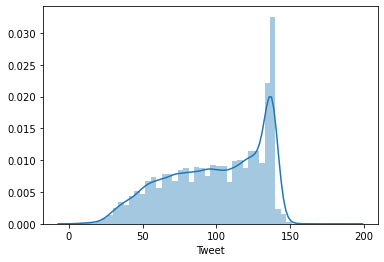

In [24]:
# A birdview of headline length. Seems the majority has a length of 70, that's about 5 to 15 words, which makes sence.
sbs.distplot(df.Tweet.str.len())

The data is well-balanced, which is rare in reality but great for our practicing purpose.

Now we will try Naive Bayes as our base model.

## Building Base Model: Naive Bayes
First step, we should tokenize texts into vectors.

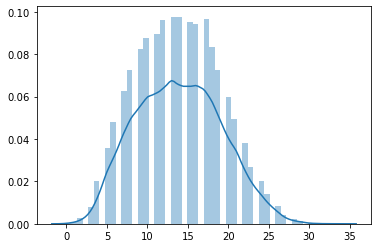

In [25]:
vocab_size = 10000 # max_features 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.Tweet)
train_inputs = tokenizer.texts_to_sequences(df.Tweet)
sbs.distplot([len(l) for l in train_inputs])

See, the above graph confirms our guess: most headline has 5 - 15 words. 


In [26]:
train_inputs = tf.keras.preprocessing.sequence.pad_sequences(train_inputs, padding='post', maxlen=20)
train_labels = df['Label']

# Split data into train /validation 
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(train_inputs, train_labels, test_size=0.2, random_state=0)
train_inputs[0]

array([   8,   21, 1479,   54,   69,   38,  340,  293,   27,   58,  490,
         28,    4,  131,    0,    0,    0,    0,    0,    0], dtype=int32)

In [27]:
nb = sklearn.naive_bayes.MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Validate how the model performs. 

Turs out that the `accuracy_score` is only 0.58, which is merely a little better than random guess.
But at least wew know what to expect now. We're going to try more powerful models, e.g., CNN, to see whether we can reach a `accuracy_score = 0.7` or higher.

In [28]:
y_preds = nb.predict(X_val)
print(f"Accuracy score", sklearn.metrics.accuracy_score(y_val, y_preds))
print(f"Classification report\n", sklearn.metrics.classification_report(y_val, y_preds))

Accuracy score 0.5434916244044875
Classification report
               precision    recall  f1-score   support

           0       0.66      0.63      0.65      8586
           1       0.34      0.38      0.36      4428

    accuracy                           0.54     13014
   macro avg       0.50      0.50      0.50     13014
weighted avg       0.55      0.54      0.55     13014



# Another model: Keras LSTM

In [ ]:
max_len = 20
text_input = tf.keras.Input(shape=(max_len, ))
embed_text = tf.keras.layers.Embedding(vocab_size, 128)(text_input)

net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embed_text)
net = tf.keras.layers.GlobalMaxPool1D()(net)
net = tf.keras.layers.Dense(64, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(32, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)

output = tf.keras.layers.Dense(1, activation='sigmoid')(net)
model = tf.keras.models.Model(text_input, output)
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint('model_best.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=256, callbacks=[mc, es], 
                    validation_split=0.1, verbose=1)

In [ ]:
model = tf.keras.models.load_model('model_best.hdf5')
y_preds = model.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds))

In [ ]:
%%time
import gensim.downloader as api

def embed_word_vector(word_index, pretrained='word2vec-google-news-300'):
    embed_size = 300 # Google news vector is 300-dimensional
    vector = api.load(pretrained)
    zeros = [0] * embed_size
    matrix = np.zeros((vocab_size, embed_size)) 
    
    for word, i in word_index.items():
        if i >= vocab_size or word not in vector: continue 
        matrix[i] = vector[word]
    
    print("Embed word vector completed.")
    return matrix

In [ ]:
%%time
pretrained = 'glove-wiki-gigaword-300'
matrix = embed_word_vector(tokenizer.word_index, pretrained=pretrained)

In [ ]:
max_len = 20
text_input = tf.keras.Input(shape=(max_len, ))
embed_text = tf.keras.layers.Embedding(vocab_size, 300, weights=[matrix], trainable=False)(text_input)

net = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embed_text)
net = tf.keras.layers.GlobalMaxPool1D()(net)
net = tf.keras.layers.Dense(64, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(32, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)

output = tf.keras.layers.Dense(1, activation='sigmoid')(net)
model = tf.keras.models.Model(text_input, output)
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint('model_best_embed.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=256, callbacks=[mc, es], 
                    validation_split=0.1, verbose=1)

In [ ]:
model = tf.keras.models.load_model('model_best_embed.hdf5')
y_preds = model.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds))

# BERT, NLP text classification killer

In [21]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [30]:
!pip install tokenization

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [43]:
!pip install bert-tensorflow==1.0.1

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [35]:
%%time
import tensorflow_hub as hub 
#import tokenization
from bert import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 4.36 s, sys: 587 ms, total: 4.95 s
Wall time: 4.8 s


In [36]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [37]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [46]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

Remember in previous sections, we have explored on the headline length. Most of them has a length between 50 to 150, and the majority has a length of 70. We set the length to 120.

In [47]:
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(df.Tweet, df['Label'], 
                                                                          test_size=0.1, random_state=0)
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)

Let's build the model and train on it.

In [48]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [49]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

train_history = model.fit(
    X_train, y_train, 
    validation_split=0.1,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=16,
    verbose=1
)

Train on 52704 samples, validate on 5856 samples
Epoch 1/3
52688/52704 [============================>.] - ETA: 0s - loss: 0.3391 - accuracy: 0.8242
Epoch 00001: val_accuracy improved from -inf to 0.83248, saving model to model.h5
52704/52704 [==============================] - 709s 13ms/sample - loss: 0.3390 - accuracy: 0.8242 - val_loss: 0.3175 - val_accuracy: 0.8325
Epoch 2/3
52688/52704 [============================>.] - ETA: 0s - loss: 0.3220 - accuracy: 0.8317
Epoch 00002: val_accuracy did not improve from 0.83248
52704/52704 [==============================] - 692s 13ms/sample - loss: 0.3220 - accuracy: 0.8317 - val_loss: 0.3191 - val_accuracy: 0.8309
Epoch 3/3
52688/52704 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.8339
Epoch 00003: val_accuracy improved from 0.83248 to 0.83367, saving model to model.h5
52704/52704 [==============================] - 694s 13ms/sample - loss: 0.3166 - accuracy: 0.8339 - val_loss: 0.3171 - val_accuracy: 0.8337
CPU times: u

In [50]:
%%time
model.load_weights('model.h5')
y_preds = model.predict(X_val).round().astype(int)
print("Validation accuracy: ", sklearn.metrics.accuracy_score(y_val, y_preds))

Validation accuracy:  0.8412478868910405
CPU times: user 25.5 s, sys: 239 ms, total: 25.7 s
Wall time: 26 s


In [58]:
"""def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
def cm(y_pred):
    y_true = testing_labels
    target_names = ['class 0', 'class 1']
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    f = sns.heatmap(cm, annot=True, fmt='d')
    
def roc(probs):
    preds = probs[:,0]
    fpr, tpr, threshold = metrics.roc_curve(testing_labels, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()"""

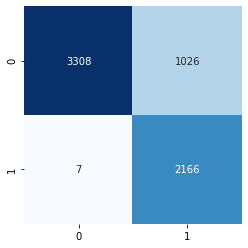

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
matrix_confusion = confusion_matrix(y_val, y_preds)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

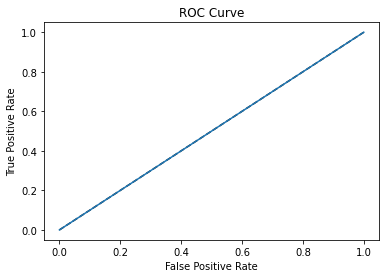

In [57]:
# Import necessary modules
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
# Compute predicted probabilities: y_pred_prob
#y_pred_prob = model.predict_proba(X_val)[:,1]


y_prob = model.predict(X_val) 
y_pred_prob = y_prob.argmax(axis=-1)


# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()